# SI 630 Project

### Fake review detection on YelpZip Dataset

This notebook is modified based on the code written by Arie Pratama Sutiono, referenced from 

https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f 

In [6]:
!pip install torchtext==0.4

     |████████████████████████████████| 61kB 3.5MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.data import Field 
from torchtext.data import Dataset, Example
from torchtext.data import BucketIterator
from torchtext.vocab import FastText
from torchtext.vocab import CharNGram

import pandas as pd
import numpy as np
import string
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
embedding_charngram = CharNGram()

.vector_cache/jmt_pre-trained_embeddings.tar.gz: 956MB [00:53, 17.9MB/s]                           
100%|█████████▉| 874452/874474 [00:43<00:00, 20025.66it/s]

In [4]:
df_review = pd.DataFrame(pd.read_table("/content/drive/MyDrive/Project/YelpZip/reviewContent",names=["user_id","name","date","review"]))

In [5]:
df_metadata = pd.DataFrame(pd.read_table("/content/drive/MyDrive/Project/YelpZip/metadata",names=["user_id", "prod_id", "rating", "label", "date"]))

In [6]:
df = pd.concat([df_review,df_metadata], axis=1,join="inner")
df = df.loc[:,~df.columns.duplicated()]

In [7]:
df.drop(columns=["user_id","name","date", "prod_id"], inplace=True)

In [8]:
df['label'] = df['label'].apply(lambda x: 0 if x == -1 else 1)

In [9]:
df['word_cnt'] = df['review'].apply(lambda x: len(x.split()))

In [10]:
def count_exlaim(review):
    count = 0
    for i in range(len(review)):
        if review[i] == '!':
            count += 1
    return count

df['exclaim_cnt'] = df['review'].apply(count_exlaim)

In [11]:
def count_caps(review):
    count = 0
    for item in review.split():
        if item.isupper():
            count += 1
    return count

df['all_cap'] = df['review'].apply(count_caps)

In [12]:
def count_sub(review):
    count = 0
    for item in review.split():
        item = item.translate(str.maketrans('', '', string.punctuation)).lower()
        if item in ['my', 'i', 'our', 'us', 'we']:
            count += 1
    return count

df['sub_cnt'] = df['review'].apply(count_sub)

In [13]:
df['review'] = df['review'].apply(lambda x: x + '<sep>')

In [14]:
def eva_rate(rating):
    if rating == 5:
        return 'excellent '
    elif rating == 4:
        return 'good '
    elif rating == 3:
        return 'average '
    else:
        return 'bad '

def eva_len(length):
    if length >= 152:
        return 'long '
    elif length < 152 and length >= 50:
        return 'medium '
    else:
        return 'short '

def eva_sub(subj):
    if subj >=  7:
        return 'subjective '
    elif subj < 7 and subj >= 3:
        return 'medium '
    else:
        return 'objective '

def eva_cap(caps):
    return 'strong ' if caps > 2 else 'weak '

def eva_exc(exclaim):
    return 'strong ' if exclaim > 1 else 'weak '

In [15]:
df.describe()

,rating,label,word_cnt,exclaim_cnt,all_cap,sub_cnt
count,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000
mean,3.923561,0.867762,115.320343,1.185720,3.568463,5.150211
std,1.147478,0.338749,106.188676,2.669422,4.623456,6.205445
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,44.000000,0.000000,1.000000,1.000000
50%,4.000000,1.000000,85.000000,0.000000,2.000000,3.000000
75%,5.000000,1.000000,152.000000,2.000000,5.000000,7.000000
max,5.000000,1.000000,5333.000000,1080.000000,276.000000,238.000000


In [16]:
df['rating_str'] = df['rating'].apply(eva_rate)
df['word_cnt_str'] = df['word_cnt'].apply(eva_len)
df['all_cap_str'] = df['all_cap'].apply(eva_cap)
df['sub_cnt_str'] = df['sub_cnt'].apply(eva_sub)
df['exclaim_cnt_str'] = df['exclaim_cnt'].apply(eva_exc)

In [17]:
df['review'] += df['rating_str'] + df['word_cnt_str'] + df['all_cap_str'] + df['sub_cnt_str'] + df['exclaim_cnt_str']

In [18]:
df_fake = df[df['label'] == 0]
df_real = df[df['label'] == 1].sample(len(df_fake), random_state=42)

In [19]:
dff = pd.concat([df_fake, df_real])

In [20]:
text_field = Field(
    sequential=True,
    tokenize='basic_english', 
    fix_length=400,
    lower=True
)

label_field = Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = dff['review'].apply(
    lambda x: text_field.preprocess(x)
)

# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='fasttext.simple.300d'
)

# get the vocab instance
vocab = text_field.vocab


.vector_cache/wiki.simple.vec: 0.00B [00:00, ?B/s]
.vector_cache/wiki.simple.vec:   0%|          | 8.19k/293M [00:00<5:08:12, 15.9kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 57.3k/293M [00:00<3:39:58, 22.2kB/s]
.vector_cache/wiki.simple.vec:   0%|          | 279k/293M [00:00<2:34:46, 31.5kB/s] 
.vector_cache/wiki.simple.vec:   0%|          | 1.17M/293M [00:00<1:48:14, 45.0kB/s]
.vector_cache/wiki.simple.vec:   1%|▏         | 3.89M/293M [00:01<1:15:08, 64.2kB/s]
.vector_cache/wiki.simple.vec:   2%|▏         | 6.71M/293M [00:01<52:09, 91.5kB/s]  
.vector_cache/wiki.simple.vec:   4%|▎         | 10.3M/293M [00:01<36:06, 131kB/s] 
.vector_cache/wiki.simple.vec:   5%|▍         | 13.7M/293M [00:01<25:01, 186kB/s]
.vector_cache/wiki.simple.vec:   6%|▌         | 17.6M/293M [00:01<17:19, 265kB/s]
.vector_cache/wiki.simple.vec:   7%|▋         | 21.4M/293M [00:01<12:00, 377kB/s]
.vector_cache/wiki.simple.vec:   9%|▊         | 25.5M/293M [00:01<08:19, 536kB/s]
.vector_cache/wiki.simple.v

In [21]:
class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [22]:
train_dataset, test_dataset = DataFrameDataset(
    df=dff[['review', 'label']], 
    fields=(
        ('review', text_field),
        ('label', label_field)
    )
).split(split_ratio=0.8)


 99%|█████████▉| 110469/111051 [00:29<00:00, 7630.37it/s]

In [23]:
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes=(16, 16),
    sort=False
)

In [28]:
class ModelParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 300)
        self.target_dim = param_dict.get('target_dim', 2)
        self.hidden_dim = param_dict.get('hidden_dim', 128)
        
class MyClfModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        self.embedding = nn.Embedding(
            model_param.vocab_size, 
            model_param.embedding_dim
        )
        
        self.lstm = nn.LSTM(
            model_param.input_size * model_param.embedding_dim, 
            model_param.hidden_dim * 2
        ).cuda()
        
        self.lin1 = nn.Linear(
            model_param.hidden_dim * 2, 
            model_param.hidden_dim
        ).cuda()
                
        self.lin2 = nn.Linear(
            model_param.hidden_dim,
            model_param.target_dim
        ).cuda()
        
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.lin1.weight.data.uniform_(-initrange, initrange)
        self.lin2.weight.data.uniform_(-initrange, initrange)
        
        self.lin1.bias.data.zero_()
        self.lin2.bias.data.zero_()
        
        
    def forward(self, x):
        features = self.embedding(x).view(x.size()[0], 1, -1)
        lstm_out, _ = self.lstm(features)
        # features = F.relu(features)
        features = self.lin1(lstm_out.view(x.size()[0], -1))
        #features = self.lin3(features)
        features = self.lin2(features)
        return features

In [29]:
torch.cuda.is_available()

True

In [30]:
!nvidia-smi

Wed Apr 28 10:07:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |   2311MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=400,
        target_dim=2
    )
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = MyClfModel(model_param)

model.to(device)
model.cuda()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

epochs = 5

train_loss = list()
train_acc = list()
test_loss = list()
test_acc = list()

for epoch in range(epochs):
    print('Starting epoch ' + str(epoch + 1) + ':')
    
    epoch_losses = list()
    epoch_accs = list()
    
    cnt_steps = 0
    for batch in train_iter:
        
        optimizer.zero_grad()

        prediction = model(batch.review.T.to(device)).cpu()
                
        loss = loss_function(prediction, batch.label)

        loss.backward()
        
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        epoch_accs.append(int((prediction.argmax(1) == batch.label).sum()) / len(batch.label))
            
    print('train loss on epoch {} : {:.3f}'.format(epoch + 1, np.mean(epoch_losses)))
    print('train acc on epoch {}: {:.3f}'.format(epoch + 1, np.max(epoch_accs)))
    train_loss.append(np.mean(epoch_losses))
    train_acc.append(np.max(epoch_accs))
    
    test_losses = list()
    test_accs = list()
    
    for batch in test_iter:
        with torch.no_grad():
            
            optimizer.zero_grad()
            
            prediction = model(batch.review.T.to(device)).cpu()
            
            loss = loss_function(prediction, batch.label)
            
            test_losses.append(loss.item())
            
            test_accs.append(int((prediction.argmax(1) == batch.label).sum()) / len(batch.label))

    
    print('test loss on epoch {}: {:.3f}'.format(epoch + 1, np.mean(test_losses)))
    print('test acc on epoch {}: {:.3f}'.format(epoch + 1, np.max(test_accs)))
    test_loss.append(np.mean(test_losses))
    test_acc.append(np.max(test_accs))

Starting epoch 1:
train loss on epoch 1 : 0.720
train acc on epoch 1: 0.938
test loss on epoch 1: 0.693
test acc on epoch 1: 0.875
Starting epoch 2:
train loss on epoch 2 : 0.720
train acc on epoch 2: 0.875
test loss on epoch 2: 0.714
test acc on epoch 2: 0.875
Starting epoch 3:
train loss on epoch 3 : 0.715
train acc on epoch 3: 0.938
test loss on epoch 3: 0.698
test acc on epoch 3: 0.875
Starting epoch 4:
train loss on epoch 4 : 0.723
train acc on epoch 4: 0.938
test loss on epoch 4: 0.694
test acc on epoch 4: 0.875
Starting epoch 5:
train loss on epoch 5 : 0.713
train acc on epoch 5: 0.938
test loss on epoch 5: 0.780
test acc on epoch 5: 0.875


Text(0.5, 0, 'epoch')

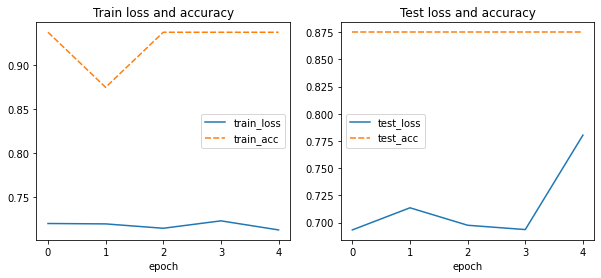

In [32]:
import matplotlib.pylab as plt
import seaborn as sns

data = pd.DataFrame({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc})

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(ax=ax1, data=data[['train_loss', 'train_acc']])
sns.lineplot(ax=ax2, data=data[['test_loss', 'test_acc']])
ax1.set_title('Train loss and accuracy')
ax2.set_title('Test loss and accuracy')
ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')